In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import  Sequential


In [7]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 384s 2us/step


In [33]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


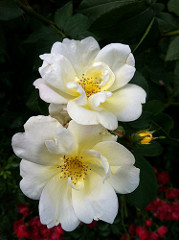

In [34]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0])) #Some rose images

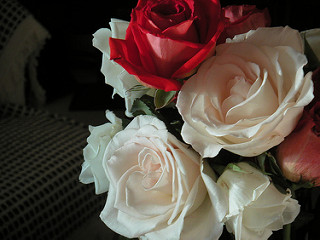

In [35]:
PIL.Image.open(str(roses[1]))

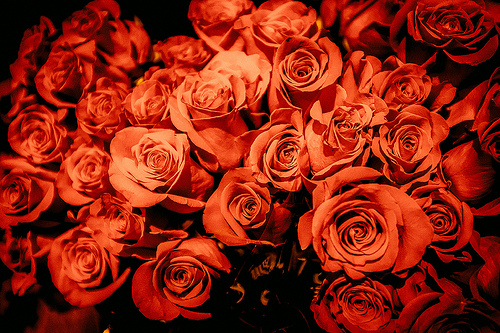

In [36]:
PIL.Image.open(str(roses[2]))

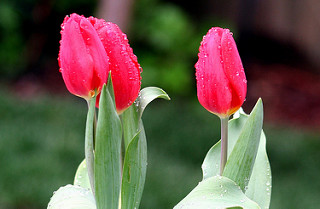

In [37]:
#Some Tupil images
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

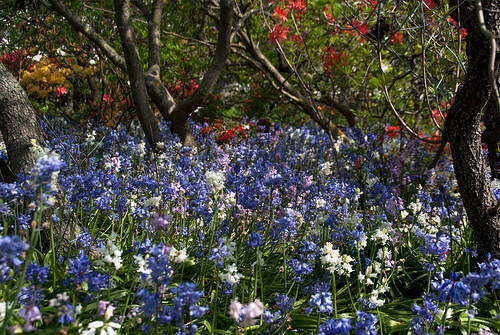

In [38]:
PIL.Image.open(str(tulips[1]))

## Create a dataset

In [39]:
#Define some parameter for loding the data
batch_size = 32
img_height = 180
img_width = 180

In [40]:
# using validation split when developing model. 
# Using 80% of the images for training and 20% for validation.

train_df = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [41]:
val_df = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [42]:
#To know the class name of each flowers
class_name  = train_df.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


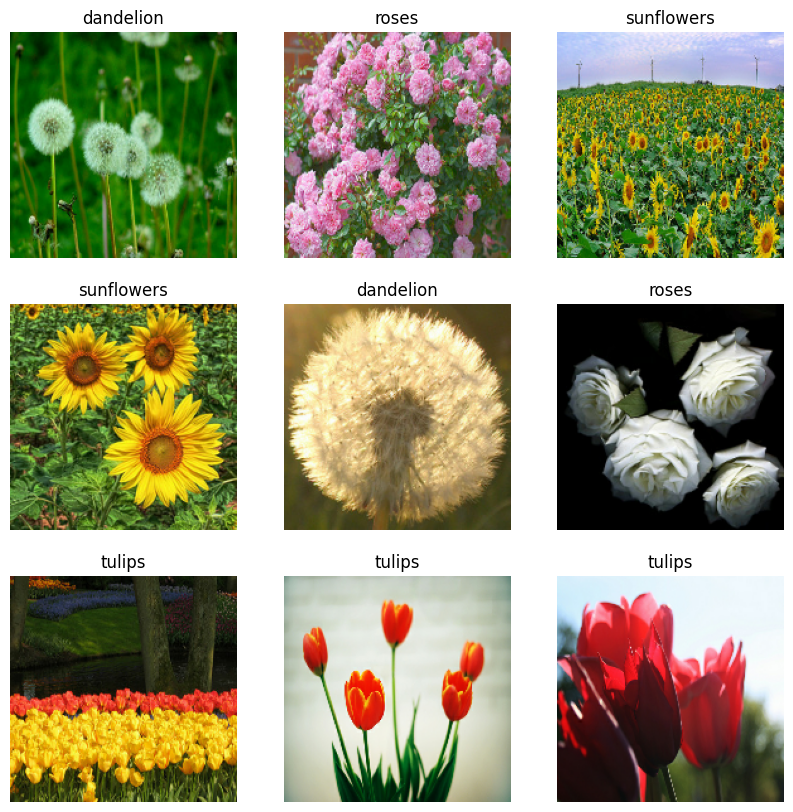

In [45]:
#visualizing the data
# first Nine images from the training dataset

plt.figure(figsize=(10,10))
for images , labels in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i +1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis('off')


In [46]:
for image_batch, labels_batch in train_df:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [47]:
#Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch
#Better to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_df = val_df.cache().prefetch(buffer_size= AUTOTUNE)

## Standardize the data

In [ ]:
#normalization_layer = layers.Rescaling(1./255)

In [ ]:
#normalized_df = train_df.map(lambda x,y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_df))
#first_image = image_batch[0]
#The pixel value are in [0, 1] now
#print(np.min(first_image), np.max(first_image))                             

0.0 0.9899673


## A basic Keras model

### Create the model

In [50]:
num_classes = len(class_name)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


### Compile the model

In [51]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

### Model summary

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [53]:
epochs = 10
history = model.fit(
    train_df,
    validation_data = val_df,
    epochs = epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.3635 - loss: 1.5456 - val_accuracy: 0.5286 - val_loss: 1.1177
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.6036 - loss: 1.0034 - val_accuracy: 0.6199 - val_loss: 0.9547
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.6889 - loss: 0.8271 - val_accuracy: 0.6499 - val_loss: 0.8976
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8040 - loss: 0.5518 - val_accuracy: 0.6635 - val_loss: 0.8821
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8596 - loss: 0.3955 - val_accuracy: 0.6608 - val_loss: 1.0339
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9233 - loss: 0.2421 - val_accuracy: 0.6253 - val_loss: 1.3389
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9531 - loss: 0.1665 - val_accuracy: 0.6553 - val_loss: 1.2550
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9825 - loss: 0.0694 - val_accuracy: 0.6376 - 

## Visualizing the data

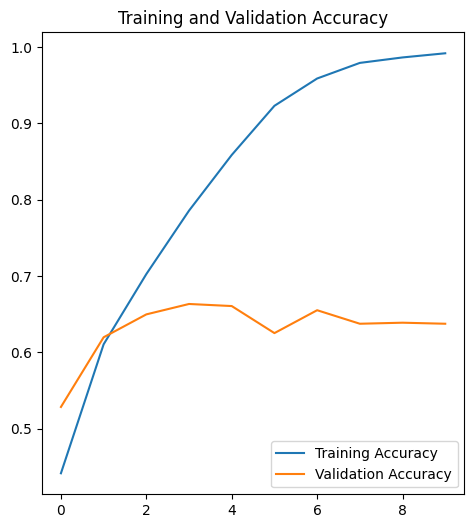

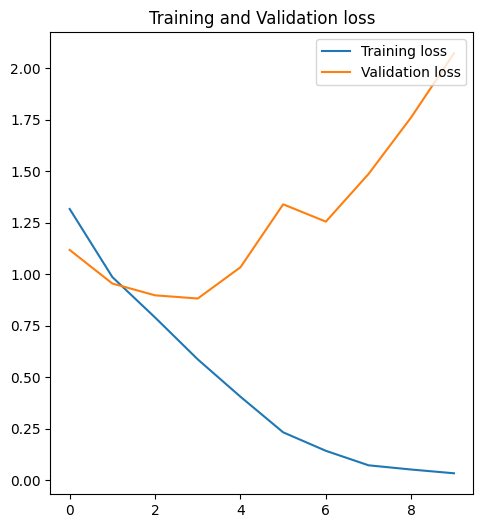

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

plt.show()




## Data Augmentation

In [59]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

C:\Users\Noel\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


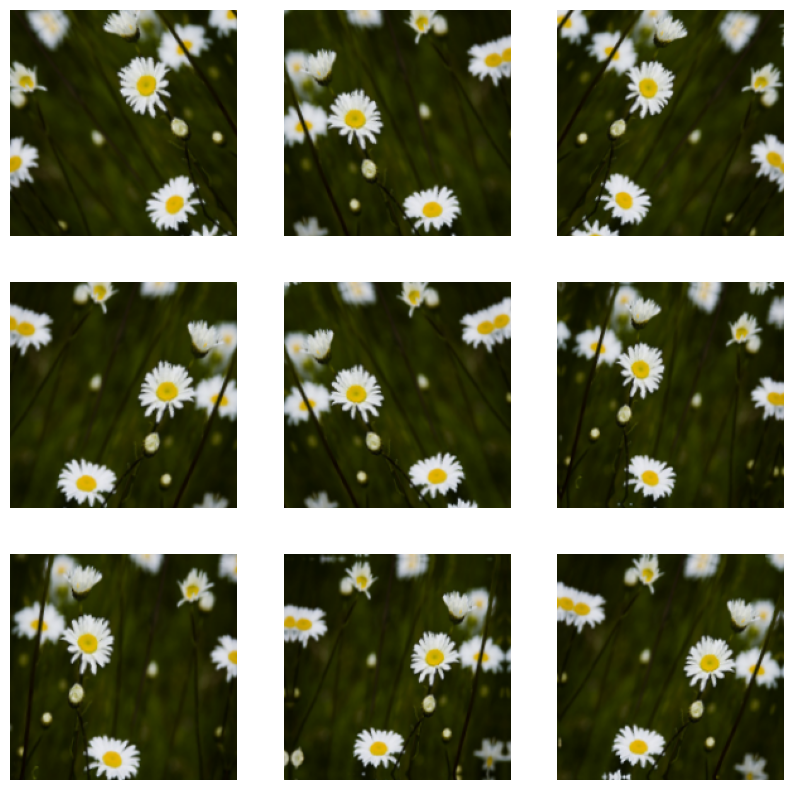

In [65]:
plt.figure(figsize=(10,10))
for images, _ in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')


## Dropout

In [70]:
# Another technique to reduce overfitting is to introduce dropout regularization to the network.

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
     

## Compile and train the model

In [71]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
epochs = 15
history = model.fit(
  train_df,
  validation_data=val_df,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.3389 - loss: 1.6317 - val_accuracy: 0.5409 - val_loss: 1.1285
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5600 - loss: 1.0984 - val_accuracy: 0.5899 - val_loss: 1.0231
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6217 - loss: 0.9810 - val_accuracy: 0.6403 - val_loss: 0.9543
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6318 - loss: 0.9433 - val_accuracy: 0.6213 - val_loss: 0.9941
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6869 - loss: 0.8451 - val_accuracy: 0.6771 - val_loss: 0.8734
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.6899 - loss: 0.8035 - val_accuracy: 0.6608 - val_loss: 0.8666
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7086 - loss: 0.7672 - val_accuracy: 0.6771 - val_loss: 0.8218
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7134 - loss: 0.7531 - val_accuracy: 0.6744 - 

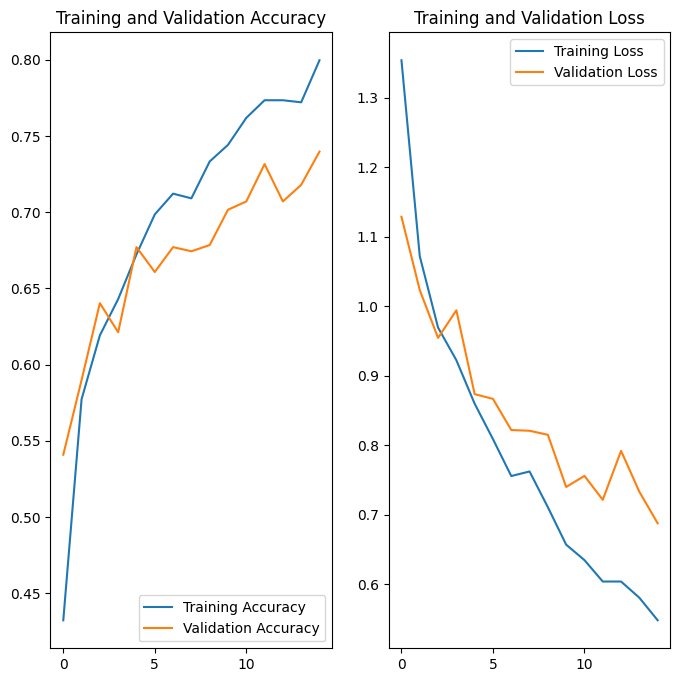

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

## predicting on new data

In [77]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to sunflowers with a 98.90 percent confidence.
